In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

In [5]:
data = np.load('test/npy/507_1.npy')

In [6]:
data

array([[618., 653.],
       [633., 647.],
       [631., 623.],
       ...,
       [267., 424.],
       [273., 439.],
       [924., 509.]], dtype=float32)

In [4]:

from roboflow import Roboflow
rf = Roboflow(api_key="OaIhIAvWOjAKrwmY0M6c")
project = rf.workspace("dth-zmcok").project("shrimp_counting-rqv6q")
version = project.version(9)
dataset = version.download("yolov12")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to shrimp_counting-9 in yolov12:: 100%|██████████| 74/74 [00:00<00:00, 1275.39it/s]


In [22]:
import os
import glob
import numpy as np
import cv2  # or from PIL import Image

IMAGES_DIR = "valid/images"
NPY_DIR = "valid/npy"
LABELS_DIR = "valid/labels"

os.makedirs(LABELS_DIR, exist_ok=True)


In [12]:
path = 'train/images/507_11.jpg'
npy_path = 'train/npy/507_11.npy'
centers = np.load(npy_path)

image = cv2.imread(path)
h, w, _ = image.shape
print(h, w)

720 1280


In [23]:

# Modify the image extension(s) below as needed:
image_paths = sorted(glob.glob(os.path.join(IMAGES_DIR, "*.jpg")))

for img_path in image_paths:
    # Example: "images/img001.jpg" -> base name = "img001"
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    # Corresponding .npy file in the 'npy' folder
    npy_path = os.path.join(NPY_DIR, f"{base_name}.npy")
    if not os.path.exists(npy_path):
        print(f"Warning: No .npy found for {img_path}, skipping.")
        continue
    
    # Load center-point(s) from .npy
    centers = np.load(npy_path)
    if centers.size == 0:
        print(f"Warning: No center points found in {npy_path}, skipping.")
        continue
    
    # Read image to get dimensions
    #   h = image height, w = image width
    image = cv2.imread(img_path)  
    if image is None:
        print(f"Could not read image {img_path}, skipping.")
        continue
    h, w, _ = image.shape
    
    # Prepare YOLO label lines
    # Format: class_id x_center y_center width height
    label_lines = []
    for center in centers:
        x_center = center[0]/ w
        y_center = center[1]/ h
        line = f"0 {x_center:.6f} {y_center:.6f} 0.01 0.01"
        label_lines.append(line)
    
    # Write to labels folder
    label_txt_path = os.path.join(LABELS_DIR, f"{base_name}.txt")
    with open(label_txt_path, "w") as f:
        f.write("\n".join(label_lines) + "\n")
    
    print(f"Saved YOLO label file: {label_txt_path}")


Saved YOLO label file: valid/labels\507_1.txt
Saved YOLO label file: valid/labels\507_10.txt
Saved YOLO label file: valid/labels\507_16.txt
Saved YOLO label file: valid/labels\507_17.txt
Saved YOLO label file: valid/labels\507_18.txt
Saved YOLO label file: valid/labels\507_19.txt
Saved YOLO label file: valid/labels\507_2.txt
Saved YOLO label file: valid/labels\507_20.txt
Saved YOLO label file: valid/labels\507_3.txt
Saved YOLO label file: valid/labels\507_4.txt
Saved YOLO label file: valid/labels\507_5.txt
Saved YOLO label file: valid/labels\507_6.txt
Saved YOLO label file: valid/labels\507_7.txt
Saved YOLO label file: valid/labels\507_8.txt
Saved YOLO label file: valid/labels\507_9.txt
Saved YOLO label file: valid/labels\IMG_ (999).txt
Saved YOLO label file: valid/labels\IMG_(s1).txt
Saved YOLO label file: valid/labels\IMG_(s10).txt
Saved YOLO label file: valid/labels\IMG_(s101).txt
Saved YOLO label file: valid/labels\IMG_(s102).txt
Saved YOLO label file: valid/labels\IMG_(s103).txt
S

In [26]:
import cv2
import numpy as np

def show_image_with_boxes(
    image_path: str,
    npy_path: str,
    box_width_norm: float = 0.01,
    box_height_norm: float = 0.01
):
    """
    Loads an image and its corresponding .npy of center points,
    draws 'tiny bounding boxes' on the image, and displays it.
    
    :param image_path: Path to the image file.
    :param npy_path: Path to the .npy file containing center points in [row, col].
    :param box_width_norm: Normalized width (e.g. 0.01).
    :param box_height_norm: Normalized height (e.g. 0.01).
    """

    # 1) Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        return
    h, w, _ = image.shape

    # 2) Load center points from .npy
    centers = np.load(npy_path)  # shape could be (N, 2) or (2,) if just one point
    if centers.ndim == 1:
        # If there's only one point, reshape to (1, 2)
        centers = centers.reshape(1, 2)
    
    # 3) For each center point, draw a tiny bounding box
    #    Using your convention: x_center = row/h, y_center = col/w,
    #    but we must convert that back to pixel coordinates for drawing.
    
    for (row, col) in centers:
        # According to your formula:
        #   x_center_norm = row / h
        #   y_center_norm = col / w
        # In pixel space (for drawing):
        x_center_px = row  # because row is literally the pixel row
        y_center_px = col  # because col is the pixel column

        # The bounding box has normalized width=box_width_norm and height=box_height_norm
        # => in pixels:
        box_w_px = box_width_norm * w
        box_h_px = box_height_norm * h
        
        # To draw with cv2.rectangle, we need top-left and bottom-right corners.
        # We'll treat (x_center_px, y_center_px) as (row, col),
        # but remember cv2 expects (x, y) = (col, row).
        
        top_left_x = int(y_center_px - (box_w_px / 2))
        top_left_y = int(x_center_px - (box_h_px / 2))
        bottom_right_x = int(y_center_px + (box_w_px / 2))
        bottom_right_y = int(x_center_px + (box_h_px / 2))
        
        # Clip coordinates so we don’t go out of image bounds:
        top_left_x = max(0, min(top_left_x, w - 1))
        top_left_y = max(0, min(top_left_y, h - 1))
        bottom_right_x = max(0, min(bottom_right_x, w - 1))
        bottom_right_y = max(0, min(bottom_right_y, h - 1))
        
        # Draw the rectangle (BGR color green=(0,255,0), thickness=2)
        cv2.rectangle(
            image,
            (top_left_x, top_left_y),
            (bottom_right_x, bottom_right_y),
            (0, 255, 0),
            2
        )
    
    # 4) Show the image in a window
    cv2.imshow("Image with bounding boxes", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()



    # Example usage:
image_file = "train/images/507_11.jpg"  # Replace with your path
npy_file = "train/npy/507_11.npy"    # Matching .npy containing center points
    
show_image_with_boxes(image_file, npy_file)


ValueError: too many values to unpack (expected 2)

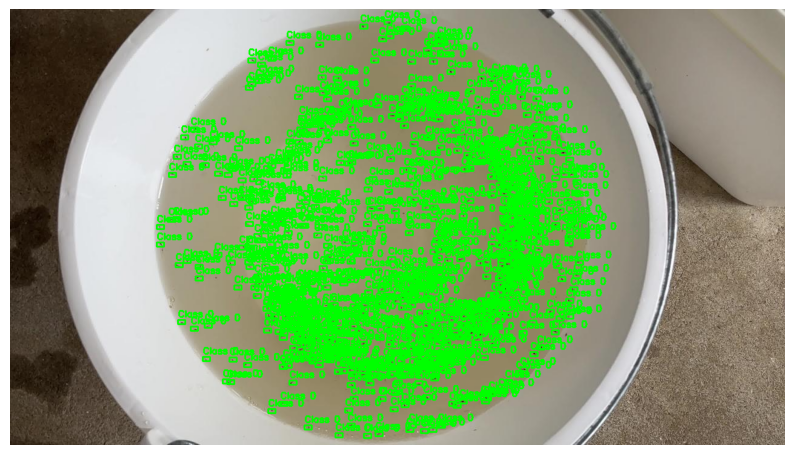

In [27]:
import cv2
import matplotlib.pyplot as plt

def draw_bounding_boxes(image_path, annotation_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found!")
        return

    # Get image dimensions
    height, width, _ = image.shape

    # Read annotations from the text file
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue  # Skip malformed lines

        class_id, center_x, center_y, box_h, box_w = map(float, parts)

        # Convert normalized coordinates to absolute pixel values
        x = int(center_x * width)
        y = int(center_y * height)
        w = int(box_w * width)
        h = int(box_h * height)

        # Get top-left corner
        x1 = int(x - w / 2)
        y1 = int(y - h / 2)
        x2 = int(x + w / 2)
        y2 = int(y + h / 2)

        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f'Class {int(class_id)}', (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Convert BGR to RGB for displaying in matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

    
# Example usage
image_path = "train/images/507_11.jpg"  # Replace with your image file
annotation_path = "train/labels/507_11.txt"  # Replace with your annotation file
draw_bounding_boxes(image_path, annotation_path)
